In [ ]:
#%load_ext autoreload
#%autoreload 2
#from main import main
#main()

In [ ]:
#OOV(w2v, ngram,2,30,0.2,damerau=True)
#np.mean(scorel) 0.866599281750797
#OOV(w2v, ngram,2,20,0.1,damerau=True)
#np.mean(scorel) 0.8698798214927248
#OOV(w2v, ngram,5,5,0.1,damerau=Fale)
# np.mean(scorel) 0.8502234726724525

return [corpus_train, corpus_val, corpus_test, sentences_train, POS_train, sentences_val, POS_val, sentences_test, POS_test, vocabulary, w2v, ngram, oov]

In [24]:
import pickle
import numpy as np

In [25]:
a = pickle.load(open("results/uni.pk","rb"))
b = pickle.load(open("results/multi.pk","rb"))
a == b

FileNotFoundError: [Errno 2] No such file or directory: 'results/uni.pk'

In [26]:
c = pickle.load(open("system/results/oov_test.pk","rb"))

In [27]:
len(c)

309

In [28]:
d = pickle.load(open("system/results/parse_results.pk","rb"))

In [12]:
len(d)

309

In [29]:
scores = pickle.load(open("system/results/scores.pk","rb"))

In [30]:
print(len(scores[scores==-np.infty]))
print(np.mean(scores[scores!=-np.infty]))

85
0.8889803033405533


In [31]:
85/309

0.2750809061488673

In [32]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
sns.set(style="whitegrid")
%matplotlib inline

In [42]:
import os
os.chdir('system')
os.getcwd()
os.listdir()

['__pycache__',
 'Ngram.py',
 'results',
 'PCFG.py',
 'main.py',
 'CYK.py',
 'data',
 'config.py',
 'run.sh',
 'eval.py',
 'utils.py',
 'Word2Vec.py',
 'OOV.py']

In [43]:
from utils import *
print("Loading corpus ...")
corpus = read("data/sequoia-corpus+fct.mrg_strict")
# split corpus
print("Splitting corpus ...")
corpus_train, corpus_val, corpus_test = split(corpus,train=0.9, val=0, test=0.1)

print("Train corpus length : {} ({:.0f}%)".format(len(corpus_train),len(corpus_train)/len(corpus)*100))
print("Valid corpus length : {} ({:.0f}%)".format(len(corpus_val),len(corpus_val)/len(corpus)*100))
print("Test corpus length : {} (Last {:.0f}%)".format(len(corpus_test),len(corpus_test)/len(corpus)*100),"\n")

# extract sentences (leaves of trees) as list of list of words
sentences_train, POS_train = extract_sentences(corpus_train)
sentences_val, POS_val = extract_sentences(corpus_val)
sentences_test, POS_test = extract_sentences(corpus_test)

Loading corpus ...
Splitting corpus ...
Train corpus length : 2790 (90%)
Valid corpus length : 0 (0%)
Test corpus length : 309 (Last 10%) 



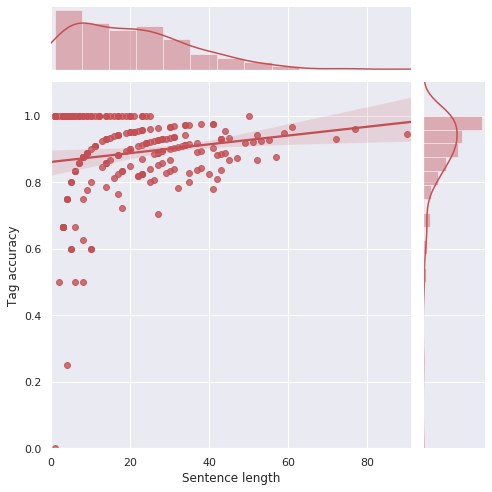

In [46]:
nb_err = []
size = []
for i in range(len(scores)):
    if scores[i]==-np.infty:
        continue
    size += [len(sentences_test[i])]
    nb_err += [scores[i]]
 
data = pd.DataFrame({'Tag accuracy':nb_err , 'Sentence length':size})

sns.set(style="darkgrid")

tips = sns.load_dataset("tips")
g = sns.jointplot('Sentence length', 'Tag accuracy', data=data,
                  kind="reg", truncate=False,
                  xlim=(0, np.max(size)+1), ylim=(0, 1.1),
                  color="r", height=7)

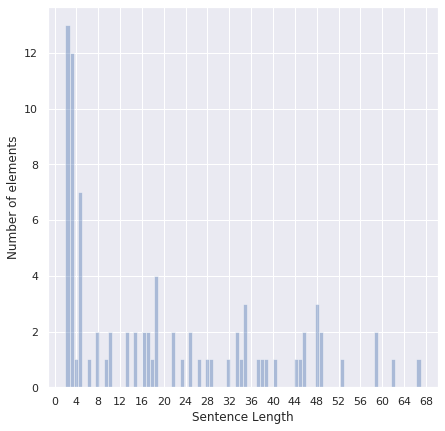

In [58]:
size = []
for i in range(len(scores)):
    if scores[i]==-np.infty:
        size += [len(sentences_test[i])]

f, ax = plt.subplots(figsize=(7, 7))
ax.set_xticks(range(0,84,4))
sns.distplot(size, bins=84, kde=False, ax=ax, axlabel=("Sentence Length"))
ax.set_ylabel("Number of elements");

In [47]:
nb_err = []
size = []
for i in range(len(scores)):
    if scores[i]==-np.infty:
        continue
    size += [len(sentences_test[i])]
    nb_err += [scores[i]]
 
data1 = pd.DataFrame({'Tag accuracy':nb_err , 'Sentence length':size})

In [48]:
size = []
for i in range(len(scores)):
    if scores[i]==-np.infty:
        size += [len(sentences_test[i])]

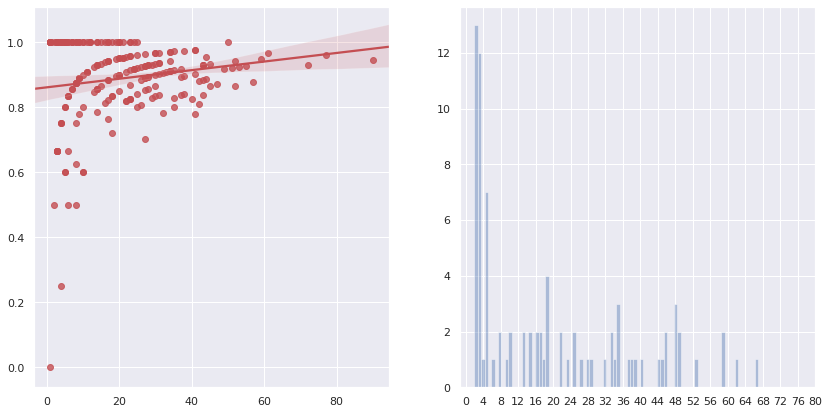

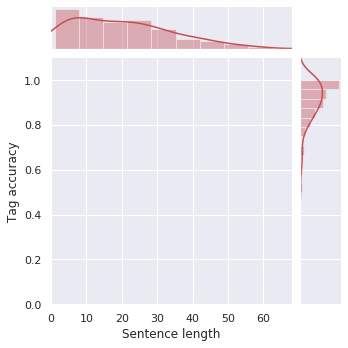

In [52]:
sns.set(style="darkgrid")
tips = sns.load_dataset("tips")

f, (ax1,ax2) = plt.subplots(1,2, figsize=(14, 7))
sns.distplot(size, bins=84, kde=False, ax=ax2)
ax2.set_xticks(range(0,84,4))

g = sns.jointplot('Sentence length', 'Tag accuracy', data=data,
                  kind="reg", truncate=False,
                  xlim=(0, np.max(size)+1), ylim=(0, 1.1),
                  color="r", ax=ax1, height=5)

In [47]:
s.value_counts().sort_index()

2     13
3     12
4      1
5      7
6      1
8      2
9      1
10     2
13     2
15     2
16     2
17     2
18     1
19     4
22     2
23     1
25     2
26     1
28     1
29     1
32     1
33     2
34     1
35     3
37     1
38     1
39     1
40     1
44     1
45     1
46     2
48     3
49     2
53     1
59     2
62     1
67     1
dtype: int64

In [9]:
import pickle
import numpy as np
import itertools 


class Word2Vec():
	"""Store embeddings """

	def __init__(self, filepath):

		## Items from the whole polyglot dataset
		self.words, self.embeddings = pickle.load(open(filepath, 'rb'),encoding='latin-1')
		# Mappings for O(1) retrieval:
		self.word2id = {word: idx for idx, word in enumerate(self.words)}
		self.id2word = {idx: word for idx, word in enumerate(self.words)}
		self.embeddings_shape = self.embeddings.shape[1]
		
	
	   
	def encode(self, word):
		"""Return embedding of a word from the vocabulary
		If the word is not present in the vocabulary, return an array of 0s
		
		Parameters
		----------
		word : str
			query word
			
		Returns
		-------
		embedding : array-like, shape (300,)
		"""
		
		idx = self.word2id.get(word, -1)
		if idx == -1:
			#print("Word {} is not included in the vocabulary".format(word))
			return np.zeros(self.embeddings.shape[1])
			
		return self.embeddings[idx]
		
			
	def score(self, word1, word2, encoded=False):
		"""Return cosine similarity between word1 and word2
		If encoded==True both words are assumed to be in encoded format
		If encoded==False both words are assumed to be in string format
		
		Parameters
		----------
		word1, word2 : str if encoded==False else array-like (shape, (300,))
			query words
		encoded: bool, default: False
			
		Returns
		-------
		score : float
			cosine similarity
		"""

		if encoded:
			e1,e2 = word1,word2
		else:
			e1,e2 = self.encode(word1),self.encode(word2)

		if np.sum(e1)==0 or np.sum(e2)==0: return 0
		
		# cosine similarity
		score = np.dot(e1, e2)  / (np.linalg.norm(e1)*np.linalg.norm(e2))
		
		return score    




	def most_similar_embeddings(self, word, k=1):
		"""Return k most similar words to 'word' in term of cosine similarity
		
		Parameters
		----------
		word : str 
			query word
		k : int, default: 5
			number of similar words
			
		Returns
		-------
		similar_words: list
		"""

		idx = self.word2id.get(word, -1)
		if idx == -1:
			#print("Word {} is not included in polyglot".format(word))
			return []
		word  = self.embeddings[idx]

		scores = [self.score(word, w, encoded=True) for w in self.embeddings]
		closest_k = np.argsort(scores)[::-1][:k]
		
		return [self.id2word[i] for i in closest_k]


In [10]:
w2v = Word2Vec("system/data/polyglot-fr.pkl")

In [22]:
w2v.most_similar_embeddings("alimenter",k=20)

['alimenter',
 'approvisionner',
 'évacuer',
 'exploiter',
 'isoler',
 'emprunter',
 'implanter',
 'abriter',
 'administrer',
 'éliminer',
 'héberger',
 'adapter',
 'élargir',
 'entrainer',
 'acheminer',
 'introduire',
 'équilibrer',
 'affecter',
 'englober',
 'exporter']